# 纽约出租车出行数据分析

基于乘客上车地点，下车地点等数据对行程时间进行预测。

## 导入库

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.linear_model import LinearRegression
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
taxi=pd.read_csv('train.csv')

In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


没有缺失值，但是不排除有错误数据的情况。

In [4]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [5]:
np.max(taxi['pickup_datetime'])

'2016-06-30 23:59:39'

In [6]:
taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


可看出，乘客数量中最大值达到9人，我们假设一辆出租车只能搭载4名乘客，所以9人是不合理的；而最小值为0也不合理。坐标中最大最小值明显已不在纽约市区。而路程时间最高为3526282秒（约40天），最低为1秒，也不符合常理。

In [7]:
Counter(taxi['passenger_count'])

Counter({1: 1033540,
         6: 48333,
         4: 28404,
         2: 210318,
         3: 59896,
         5: 78088,
         0: 60,
         7: 3,
         9: 1,
         8: 1})

依据乘客人数统计接单数，我们决定剔除掉乘客数为0,7,8,9的数据。

## 数据清理

将不需要的列‘id’，‘vendor_id’，‘store_and_fwd_flag’去除。

In [8]:
taxi=taxi.drop(columns=['id','vendor_id','store_and_fwd_flag'])

处理不合理的坐标数据。

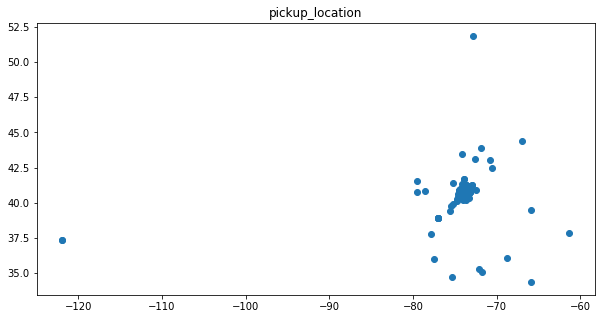

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(taxi['pickup_longitude'],taxi['pickup_latitude'])
plt.title('pickup_location')
plt.show()

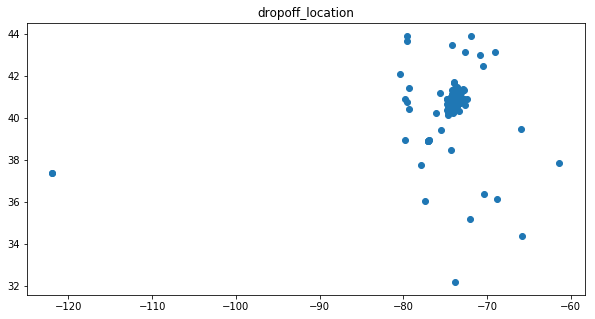

In [10]:
plt.figure(figsize=(10,5))
plt.scatter(taxi['dropoff_longitude'],taxi['dropoff_latitude'])
plt.title('dropoff_location')
plt.show()

In [11]:
taxi=taxi[taxi['dropoff_latitude']>40.490973]
taxi=taxi[taxi['dropoff_latitude']<40.914561]
taxi=taxi[taxi['dropoff_longitude']>-74.277667]
taxi=taxi[taxi['dropoff_longitude']<-73.697400]
taxi=taxi[taxi['pickup_latitude']>40.490973]
taxi=taxi[taxi['pickup_latitude']<40.914561]
taxi=taxi[taxi['pickup_longitude']>-74.277667]
taxi=taxi[taxi['pickup_longitude']<-73.697400]

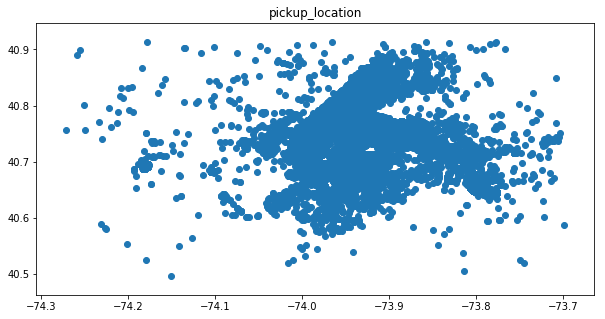

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(taxi['pickup_longitude'],taxi['pickup_latitude'])
plt.title('pickup_location')
plt.show()

接下来剔除旅程用时不合理的数据。

这里先作出旅程用时的箱线图。

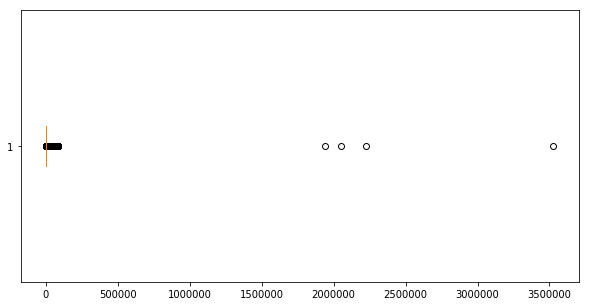

In [13]:
plt.figure(figsize=(10,5))
plt.boxplot(taxi['trip_duration'],vert=False)
plt.show()

计算旅程用时的$Q_1$，$Q_2$，并计算四分位距。

In [14]:
Q=np.percentile(taxi['trip_duration'], [25, 50, 75])
IQR=Q[2]-Q[0]
lower=Q[0]-1.5*IQR
upper=Q[2]+1.5*IQR

In [15]:
IQR

677.0

使用IQR去除极端值。在这里也剔除掉行程时间低于5分钟的。

In [16]:
taxi=taxi[taxi['trip_duration']>300]
taxi=taxi[taxi['trip_duration']<upper]

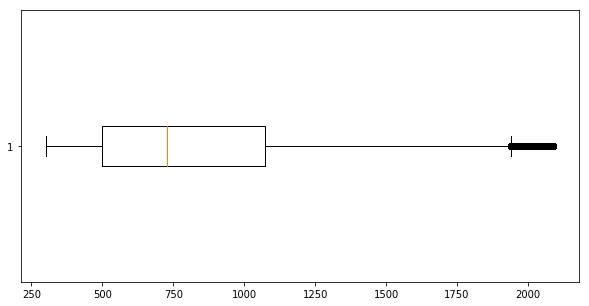

In [17]:
plt.figure(figsize=(10,5))
plt.boxplot(taxi['trip_duration'],vert=False)
plt.show()

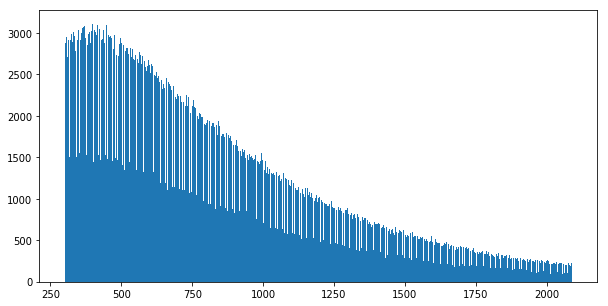

In [18]:
plt.figure(figsize=(10,5))
plt.hist(taxi['trip_duration'],bins=1000)
plt.show()

还应考虑到旅程与用时不匹配的问题，例如在很短的时间内出租车跑了很长一段距离。这里使用曼哈顿距离计算里程，然后计算车速。

In [19]:
distance=[]
for po,pa,do,da in zip(taxi['pickup_longitude'],taxi['pickup_latitude'],taxi['dropoff_longitude'],taxi['dropoff_latitude']):
    distance.append(np.absolute(po-do)*111*np.cos(np.absolute(pa-da))+np.absolute(pa-da)*111)
    
taxi['distance']=distance

In [20]:
taxi.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance
count,1161756.000,1161756.000,1161756.000,1161756.000,1161756.000,1161756.000,1161756.000
mean,1.667,-73.977,40.751,-73.975,40.752,831.751,4.804
std,1.314,0.031,0.025,0.031,0.031,417.733,4.542
min,0.000,-74.251,40.496,-74.271,40.496,301.000,0.000
25%,1.000,-73.992,40.737,-73.992,40.736,497.000,2.163
50%,1.000,-73.982,40.753,-73.980,40.754,727.000,3.376
75%,2.000,-73.970,40.767,-73.964,40.769,1074.000,5.673
max,9.000,-73.705,40.911,-73.698,40.915,2089.000,52.660


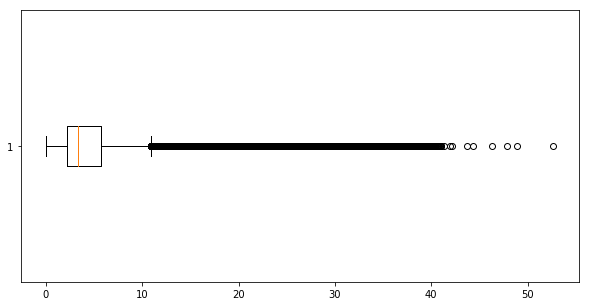

In [21]:
plt.figure(figsize=(10,5))
plt.boxplot(taxi['distance'],vert=False)
plt.show()

剔除行程低于1公里的行。

In [22]:
taxi=taxi[taxi['distance']>1]

In [23]:
speed=[]
for s,t in zip(taxi['distance'],taxi['trip_duration']):
    speed.append(s/(t/3600))

taxi['speed']=speed

In [24]:
taxi.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,speed
count,1128255.000,1128255.000,1128255.000,1128255.000,1128255.000,1128255.000,1128255.000,1128255.000
mean,1.666,-73.977,40.751,-73.975,40.752,840.174,4.927,20.630
std,1.314,0.031,0.025,0.031,0.031,417.809,4.551,11.383
min,0.000,-74.231,40.525,-74.271,40.531,301.000,1.000,1.767
25%,1.000,-73.992,40.737,-73.992,40.735,506.000,2.256,12.994
50%,1.000,-73.982,40.753,-73.980,40.754,737.000,3.464,17.982
75%,2.000,-73.969,40.767,-73.964,40.769,1084.000,5.787,25.109
max,6.000,-73.709,40.911,-73.698,40.915,2089.000,52.660,257.018


可以看到车速中有0的，也有高达15062km/h的，显然不合理。剔除车速大于100km/h的数据，同时删除车速为0的数据。

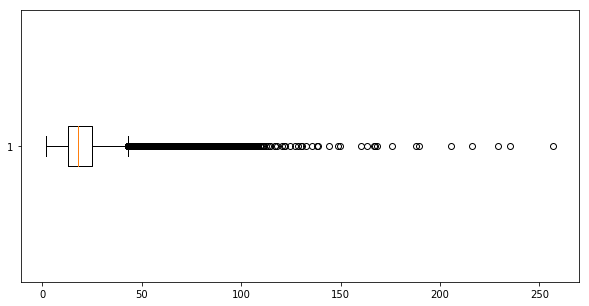

In [25]:
plt.figure(figsize=(10,5))
plt.boxplot(taxi['speed'],vert=False)
plt.show()

In [26]:
taxi=taxi[taxi['speed']>0]
taxi=taxi[taxi['speed']<=100]

In [27]:
taxi.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,speed
count,1128161.000,1128161.000,1128161.000,1128161.000,1128161.000,1128161.000,1128161.000,1128161.000
mean,1.666,-73.977,40.751,-73.975,40.752,840.177,4.926,20.622
std,1.314,0.031,0.025,0.031,0.031,417.816,4.547,11.342
min,0.000,-74.178,40.525,-74.271,40.531,301.000,1.000,1.767
25%,1.000,-73.992,40.737,-73.992,40.735,506.000,2.256,12.994
50%,1.000,-73.982,40.753,-73.980,40.754,737.000,3.463,17.981
75%,2.000,-73.969,40.767,-73.964,40.769,1084.000,5.786,25.106
max,6.000,-73.709,40.911,-73.698,40.915,2089.000,48.934,99.861


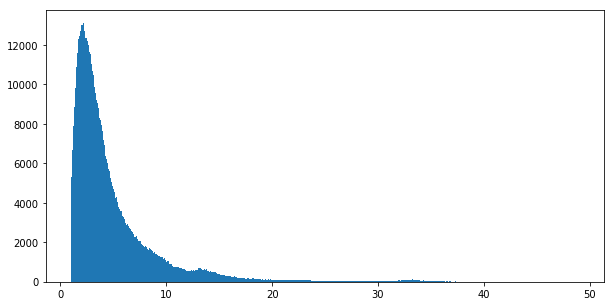

In [28]:
plt.figure(figsize=(10,5))
plt.hist(taxi['distance'],bins=1000)
plt.show()

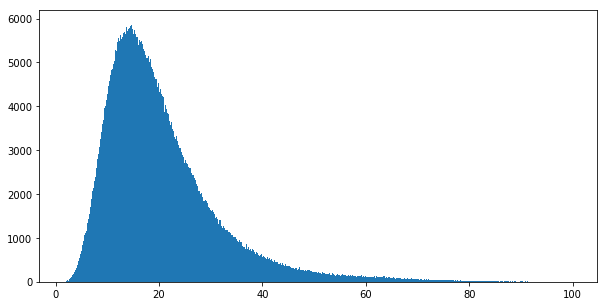

In [29]:
plt.figure(figsize=(10,5))
plt.hist(taxi['speed'],bins=1000)
plt.show()

删除乘客数量不合理的数据。

In [30]:
taxi=taxi[taxi['passenger_count']>0]
taxi=taxi[taxi['passenger_count']<=6]

In [31]:
taxi.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,speed
count,1128152.000,1128152.000,1128152.000,1128152.000,1128152.000,1128152.000,1128152.000,1128152.000
mean,1.667,-73.977,40.751,-73.975,40.752,840.177,4.926,20.622
std,1.314,0.031,0.025,0.031,0.031,417.815,4.547,11.342
min,1.000,-74.178,40.525,-74.271,40.531,301.000,1.000,1.767
25%,1.000,-73.992,40.737,-73.992,40.735,506.000,2.256,12.994
50%,1.000,-73.982,40.753,-73.980,40.754,737.000,3.463,17.981
75%,2.000,-73.969,40.767,-73.964,40.769,1084.000,5.786,25.106
max,6.000,-73.709,40.911,-73.698,40.915,2089.000,48.934,99.861


为方便统计，提取时间中的小时与日期，并加入新的列。

In [32]:
taxi['pickup_datetime']=pd.to_datetime(taxi['pickup_datetime'])

In [33]:
taxi['hour']=taxi['pickup_datetime'].dt.hour
taxi['month']=taxi['pickup_datetime'].dt.month
taxi['date']=taxi['pickup_datetime'].dt.date
taxi['day']=taxi['pickup_datetime'].dt.dayofweek

In [34]:
taxi.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,speed,hour,month,date,day
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,455,2.204,17.441,17,3,2016-03-14,0
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,663,2.939,15.958,0,6,2016-06-12,6
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,429,1.718,14.419,19,4,2016-04-06,2
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,435,1.201,9.938,13,3,2016-03-26,5
5,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.983,40.742,-73.992,40.749,443,1.800,14.624,22,1,2016-01-30,5


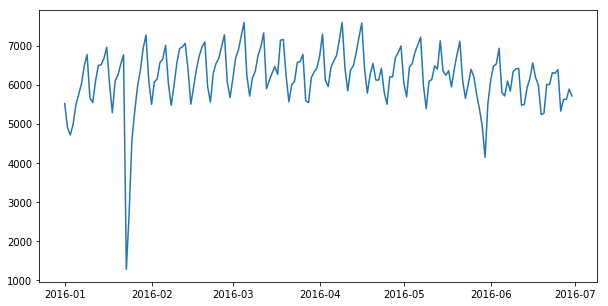

In [35]:
Date=Counter(taxi['date'].sort_values())
plt.figure(figsize=(10,5))
plt.plot(Date.keys(),Date.values() )
plt.show()

可见每日出租车接单数呈周期变化（猜测局部最小值处为周末），在一月底与5月底出租车接单数明显低于平时（考虑到1月为冬季，这一天可能出现了暴雪天气）。

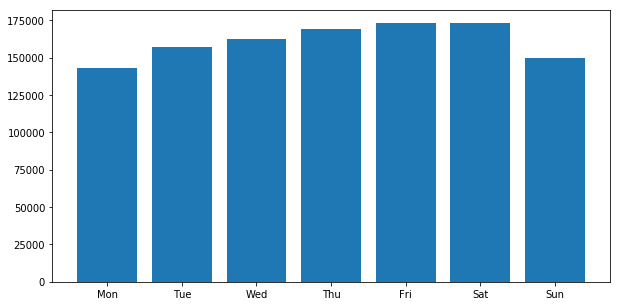

In [36]:
Day=Counter(taxi['day'].sort_values())
plt.figure(figsize=(10,5))
plt.bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],Day.values())
plt.show()

然而如果依据一周七天统计，并不能发现什么规律。

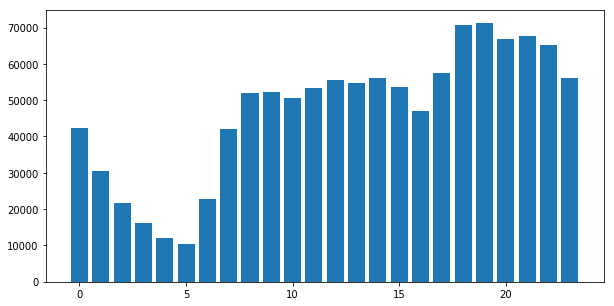

In [37]:
Hour=Counter(taxi['hour'].sort_values())
plt.figure(figsize=(10,5))
plt.bar(Hour.keys(),Hour.values() )
plt.show()

接单数最多为下午18至19点，最少为上午4到5点。

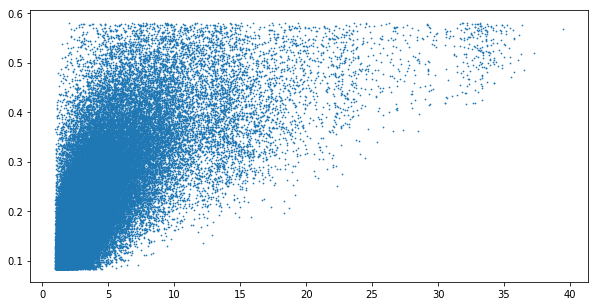

In [38]:
plt.figure(figsize=(10,5))
plt.scatter(taxi[taxi['hour']==19]['distance'],np.array(taxi[taxi['hour']==19]['trip_duration']/3600) ,s=0.5)
plt.show()

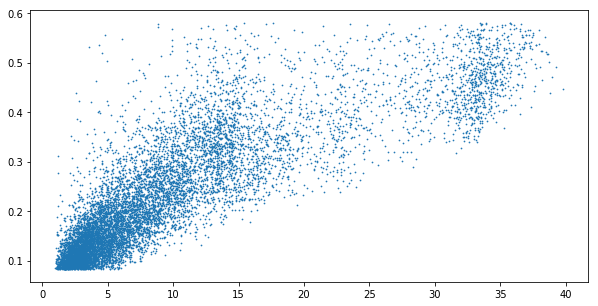

In [39]:
plt.figure(figsize=(10,5))
plt.scatter(taxi[taxi['hour']==5]['distance'],np.array(taxi[taxi['hour']==5]['trip_duration']/3600) ,s=0.5)
plt.show()

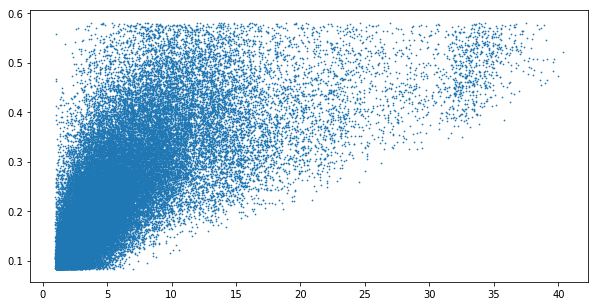

In [40]:
plt.figure(figsize=(10,5))
plt.scatter(taxi[taxi['hour']==23]['distance'],np.array(taxi[taxi['hour']==23]['trip_duration']/3600) ,s=0.5)
plt.show()

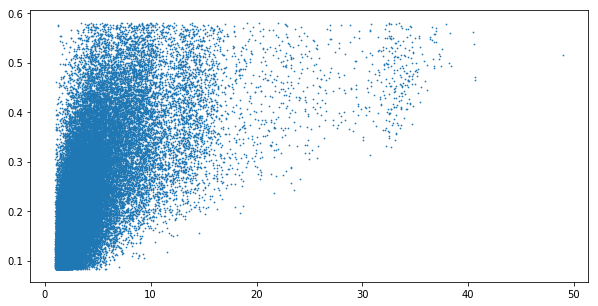

In [41]:
plt.figure(figsize=(10,5))
plt.scatter(taxi[taxi['hour']==8]['distance'],np.array(taxi[taxi['hour']==8]['trip_duration']/3600) ,s=0.5)
plt.show()

这里绘制出上午5点，8点，晚上19点，23点路程与时间散点图。

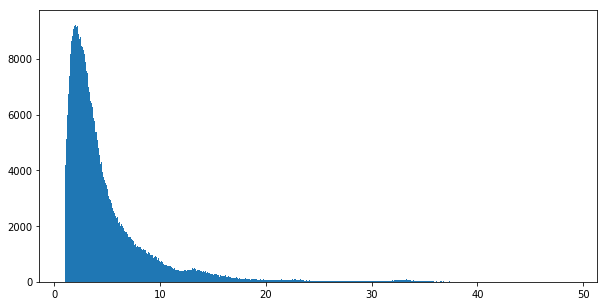

In [44]:
plt.figure(figsize=(10,5))
plt.hist(taxi[taxi['passenger_count']==1]['distance'] ,bins=1000)
plt.show()

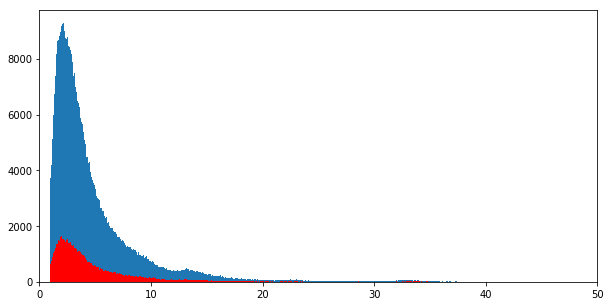

In [54]:
plt.figure(figsize=(10,5))

plt.hist(taxi[taxi['passenger_count']==1]['distance'] ,bins=1000)
plt.hist(taxi[taxi['passenger_count']==2]['distance'] ,bins=1000,color='r')
plt.xlim(0,50)
plt.show()

将时间（小时）向量化

In [56]:
taxi= pd.get_dummies(taxi,columns = ['hour'],drop_first=True)

In [57]:
taxi.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,speed,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,455,2.204,17.441,...,0,0,0,1,0,0,0,0,0,0
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,663,2.939,15.958,...,0,0,0,0,0,0,0,0,0,0
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,429,1.718,14.419,...,0,0,0,0,0,1,0,0,0,0
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,435,1.201,9.938,...,0,0,0,0,0,0,0,0,0,0
5,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.983,40.742,-73.992,40.749,443,1.800,14.624,...,0,0,0,0,0,0,0,0,1,0


使用线性回归模型拟合数据。

In [61]:
taxi.columns

Index(['pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'distance', 'speed', 'month',
       'date', 'day', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [63]:
X=taxi[['distance','hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']]
y=taxi['trip_duration']

In [64]:
reg = LinearRegression().fit(X, y)

In [66]:
pd.DataFrame({'feature':['distance','hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],'coef':reg.coef_})

,feature,coef
0,distance,61.740
1,hour_1,-33.613
2,hour_2,-49.730
3,hour_3,-76.103
4,hour_4,-129.708
5,hour_5,-217.431
6,hour_6,-136.727
7,hour_7,7.051
8,hour_8,123.961
9,hour_9,150.598


得到$R^2$为0.43

In [68]:
reg.score(X,y)

0.43365216255233163